1. Data Exploration & Visualization

In [1]:
!pip install yfinance plotly mplfinance --quiet
import numpy as np;
import pandas as pd;
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import plotly.graph_objects as go
import plotly.express as px
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
def download(ticker,start,end):
  data=yf.download(ticker, start=start, end=end, progress=False)
  data=data.xs(ticker, axis=1, level=1)
  data.columns.name = None
  return data

stock = 'RELIANCE.NS'
data = download(stock, start='2024-01-01', end='2024-07-01')
parse_dates = ['Date']
index_col = 'Date'   #ensures datetime indexing

#handling missing values
data.interpolate(method='linear', inplace=True)
data.head()



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.9 MB/s eta 0:00:00
YF.download() has changed argument auto_adjust default to True


,Close,High,Low,Open,Volume
Date,,,,,
2024-01-01,1290.744263,1299.016237,1282.223134,1285.910692,4030540
2024-01-02,1301.432983,1303.077427,1282.148458,1288.128164,7448800
2024-01-03,1287.281006,1312.545235,1284.241274,1300.585825,9037536
2024-01-04,1293.933350,1300.511122,1285.188128,1289.623028,9612778
2024-01-05,1299.439697,1305.494222,1294.606127,1297.047791,8086406


In [2]:
fig=go.Figure(data=[go.Candlestick(x=data.index,
                                    open=data['Open'],
                                    high=data['High'],
                                    low=data['Low'],
                                    close=data['Close'])])
fig.update_layout(title=f"Candlestick Chart - {stock}", xaxis_title='Date', yaxis_title='Price')
fig.show()

1.SUDDEN DROP                          
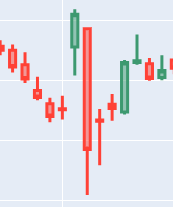

THIS LARGE RED CANDLE INDIACTES THE SUDDEN DROP IN PRICES.



2.TREND REVERSAL


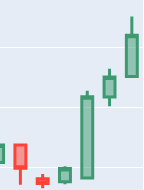

THIS SHOWS A TREND REVERSAL,  SHOWS A SHIFT FROM RED CANDLES TO GREEN CANDLES.


2. Returns & Volatility

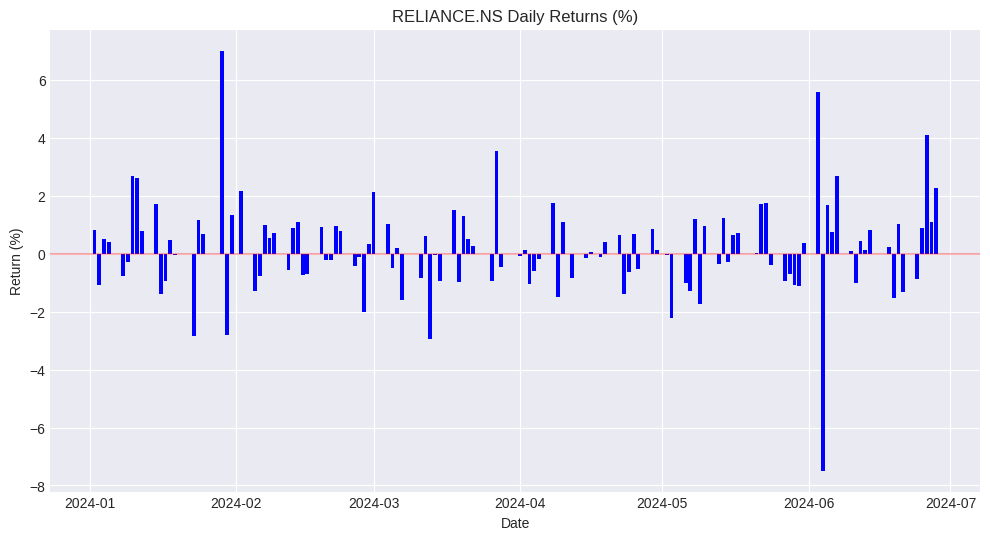

In [3]:
data['Daily Return'] = data['Close'].pct_change()
plt.figure(figsize=(12, 6))
plt.bar(data.index, data['Daily Return']*100, color='blue')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.title(f'{stock} Daily Returns (%)')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.grid(True)
plt.show()

In [4]:
data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
data[['Daily Return', 'Log Return']].dropna().head()
fig1 = px.line(data, x=data.index, y='Daily Return', title=f'{stock} Simple Returns')
fig1.show()

fig2 = px.line(data, x=data.index, y='Log Return', title=f'{stock} Log Returns')
fig2.show()

Simple Return: (P_t - P_{t-1}) / P_{t-1}

Log Return: log(P_t / P_{t-1})

for daily returns, the percentage changes are usually small(1% or even lesser)

And when pt/p_t-1 ≈ 1,

ln(1+x) = x - x^2/2 +x^3/3 - ....... (when x->0)

log(P_t / P_{t-1}) ≈ (P_t / P_{t-1})/P_{t-1}

so, they look very similar


They differ significantly when there is a large price movement and when thwe timespan is large.

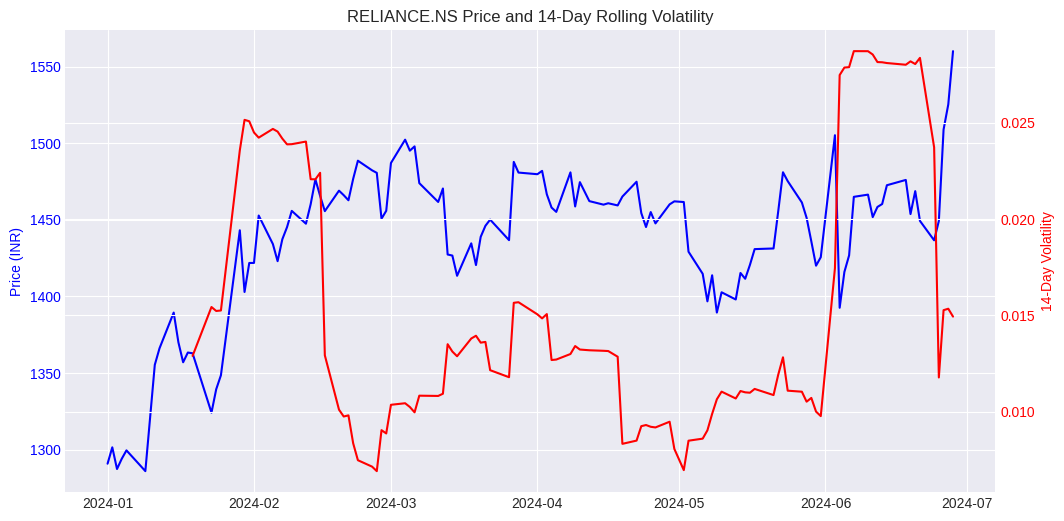

In [5]:
data['Rolling Std Dev'] = data['Daily Return'].rolling(window=14).std()
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_ylabel('Price (INR)', color='blue')
ax1.plot(data.index, data['Close'], label='Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('14-Day Volatility', color='red')
ax2.plot(data.index, data['Rolling Std Dev'], label='14-Day Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')
plt.title('RELIANCE.NS Price and 14-Day Rolling Volatility')
plt.grid(True)
plt.show()

3. The Probability Paradox


In [6]:
from scipy.stats import binom
directions = []
for i in data['Daily Return']:
  if i>0:
    directions.append('UP')
  else:
    directions.append('DOWN')


up_count = directions.count('UP')
down_count = directions.count('DOWN')
total_count = len(directions)
up_probability = up_count / total_count
print(f"Probability of going up: {up_probability}")


Probability of going up: 0.5333333333333333


In [11]:
up_probability = 0.6
#probability of exactly 6 up days
up_days = binom.pmf(k=6, n=10, p=up_probability)
print(f"Probability of exactly 6 up days: {up_days}")
#probability of atleast 8 up days
atleast_probability = binom.sf(k=7, n=10, p=up_probability)
print(f"Probability of atleast 8 up days: {atleast_probability}")
count = []
for i in range(1000):
  flips = np.random.rand(10) < up_probability
  up_count = flips.sum()
  count.append(up_count)

count = np.array(count)
sim_exactly = np.sum(count==6)/1000
sim_atleast = np.sum(count>=8)/1000
print(f"Simulated probability of exactly 6 up days: {sim_exactly}")
print(f"Simulated probability of atleast 8 up days: {sim_atleast}")

Probability of exactly 6 up days: 0.2508226559999998
Probability of atleast 8 up days: 0.16728975359999992
Simulated probability of exactly 6 up days: 0.259
Simulated probability of atleast 8 up days: 0.169


In [14]:
updays = data[data['Daily Return'] > 0]
downdays = data[data['Daily Return'] < 0]
avg_return_up = updays['Daily Return'].mean()
avg_return_down = downdays['Daily Return'].mean()
print(f"Average Daily Return for Up Days: {avg_return_up}")
print(f"Average Daily Return for Down Days: {avg_return_down}")
# total return with compounding = (1+r1)*(1+r2)......*(1+rn)-1
cummulative_return = (1+avg_return_up)**6 * (1+avg_return_down)**4 - 1
print(f"Cummulative Return: {cummulative_return}")
# if cummulative return is negative then there is overall loss which could be a possible situation if down days give more losses as compared
# to the gains by up days.

Average Daily Return for Up Days: 0.012056814626970551
Average Daily Return for Down Days: -0.010295527889000271
Cummulative Return: 0.030982970670223375


In [17]:
Expected_value = (up_probability * 100) + ((1 - up_probability) * -150)
print(f"Expected Value: {Expected_value}")

Expected Value: 0.0


I think i would not take this bet because in this expected value turns out to be zero which is the long term average outcome. Even though the probability of going up is 60% but still the donside risk is greater than the upside since I'll lose more than I'll gain. and in a long run it will be kind of neutral. Also if i win more frequently, the losses will eventually wipe out profits more quickly. so, i will not consider taking this bet.

I’m genuinely excited about this project because it aligns well with both my interests and learning goals.And this was my first preference because this data analysis, trading and all excites me a lot.  I expect to deepen my understanding of real-world data analysis, apply theoretical concepts practically, and improve my ability to draw insights from trends and probabilities.
